In [1]:
import random
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes,mark_inset
from scipy.special import expit

def smooth(x, y, window_size):
    window = np.ones(window_size)/window_size
    return x[window_size-1:], np.convolve(y, window, mode='valid')

def sample_by_otr(tokens, loss, lower_value, upper_value, model_size = 10 ** 9):
    otr = np.array(tokens) /  model_size
    sampled_tokens = [tokens[idx] for idx in range(0, len(tokens)) if otr[idx] <= upper_value and otr[idx] >= lower_value]
    sampled_loss = [loss[idx] for idx in range(0, len(loss)) if otr[idx] <= upper_value and otr[idx] >= lower_value]
    return sampled_tokens, sampled_loss
    
def sample(x, y, upper_value, lower_value):
    sampled_x = [x[idx] for idx in range(0, len(x)) if y[idx] <= upper_value and y[idx] >= lower_value]
    sampled_y = [y[idx] for idx in range(0, len(y)) if y[idx] <= upper_value and y[idx] >= lower_value]
    return sampled_x, sampled_y

def sample_loss(csv_file, tokens):
    sample_list = []
    for i in range(len(csv_file.Step)):
        if abs(csv_file.iloc[i].Step -tokens)/tokens < 0.005:    
            sample_list.append(csv_file.iloc[i].Value)
        elif (csv_file.iloc[i].Step -tokens)/tokens > 0.005:
            break
    return np.mean(np.array(sample_list))

# Define Fitting Function

In [5]:
def fit_mixed_curve_with_fixed_k1_k2(L, D, N, initial_params, max_iter=1000, tol=1e-6, epsilon=1e-8):    
    # Function to fit
    def model(params, D, N):
        alpha1, alpha2, lambda1, lambda2, k1, k2, C = params
        OTR = (np.array(D) * 10 ** 3) / np.array(N)
        R1 = 1 + 1 / (1 + np.exp(-k1 * OTR))
        R2 = 1 + 1 / (1 + np.exp(-k2 * OTR))
        return  (R1 * lambda1) / (D ** alpha1 + epsilon) + (R2 * lambda2) / (N ** alpha2 + epsilon) + C

    def huber_loss(residual, delta):
        """Computes Huber loss for a given residual and threshold delta."""
        abs_residual = np.abs(residual)
        quadratic = 0.5 * residual**2
        linear = delta * (abs_residual - 0.5 * delta)
        return np.where(abs_residual <= delta, quadratic, linear)  

    # Define the objective function to minimize
    def objective(params, D, N, L, delta=1e-3):
        """Objective function that computes the sum of Huber loss values."""
        # Calculate the predicted loss using the current model parameters
        predicted_L = model(params, D, N)

        # Compute residuals
        residuals = predicted_L - L

        # Return the sum of Huber loss values
        return np.sum(huber_loss(residuals, delta))
   
    # Set bounds to avoid numerical issues
    bounds = [(0.21, 0.29), (0.21, 0.29), (0.9, 2), (0.9, 2.6), (0., 0.081), (0.0, 0.091), (1.248, 1.349)]

    
    # Set optimization options
    options = {'maxiter': max_iter, 'disp': True, 'gtol': tol}
   
    # Optimize parameters using a more robust method
    result = scipy.optimize.minimize(objective, initial_params, args=(D, N, L),
                                      method='L-BFGS-B', bounds=bounds, options=options)    
        
    # Set optimization options
    # options = {'maxiter': max_iter, 'disp': True}
   
    # Optimize parameters using a more robust method
    # result = scipy.optimize.minimize(objective, initial_params, args=(D, N, L),
    #                                   method='Powell', bounds=bounds, options=options)
   
    # Check for optimization success
    if not result.success:
        raise RuntimeError("Optimization failed: " + result.message)
   
    # Extract optimized parameters
    alpha1, alpha2, lambda1, lambda2, k1, k2, C = result.x
    OTR = (np.array(D) * 10 ** 3) / np.array(N)
    R1 = 1 + 1 / (1 + np.exp(-k1 * OTR))
    R2 = 1 + 1 / (1 + np.exp(-k2 * OTR))
    error = np.sum(abs(model(result.x, D, N) - L)/L)/len(L)
    
   
    return alpha1, alpha2, lambda1, lambda2, k1, k2, C, error


# Loss vs N (with D fixed)

In [10]:
TOKENS = 30 * 10 ** 9
loss_value_50M = sample_loss(loss_df_50M, tokens = TOKENS)
loss_value_100M = sample_loss(loss_df_100M, tokens = TOKENS)
loss_value_300M = sample_loss(loss_df_300M, tokens = TOKENS)
loss_value_500M = sample_loss(loss_df_500M, tokens = TOKENS)
loss_value_700M = sample_loss(loss_df_700M, tokens = TOKENS)
loss_value_1B = sample_loss(loss_df_1B, tokens = TOKENS)
loss_value_2B = sample_loss(loss_df_2B, tokens = TOKENS)
loss_value_4B = sample_loss(loss_df_4B, tokens = TOKENS)
loss_value_7B = sample_loss(loss_df_7B, tokens = TOKENS)

test_N = np.array([model_size_50M, model_size_100M, model_size_300M, model_size_500M,model_size_700M, model_size_1B, model_size_2B, model_size_4B, model_size_7B])  / (10 ** 6)   #, model_size_2B, model_size_4B, model_size_7B])  
test_D = np.array(list([30]) * len(test_N))
test_L = np.array([loss_value_50M, loss_value_100M, loss_value_300M, loss_value_500M, loss_value_700M,loss_value_1B, loss_value_2B, loss_value_4B, loss_value_7B])

initial_params = [0.2803, 0.26121, 0.835279, 1.1471, 0.01709, 0.013, 1.248]
alpha1, alpha2, lambda1, lambda2, k1, k2, C, error = fit_mixed_curve_with_fixed_k1_k2(np.array(test_L[:-2]), np.array(test_D[:-2]), np.array(test_N[:-2]), initial_params)
params_with_k1_k2 = alpha1, lambda1, k1, alpha2, lambda2, k2, C

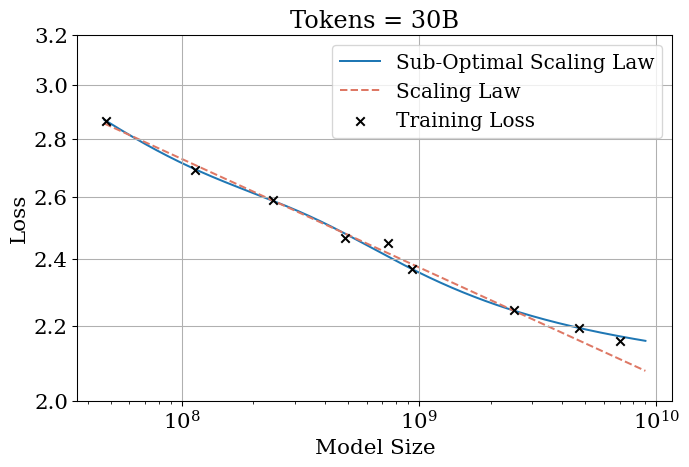

In [15]:
plt.rcParams.update({'font.size':15})

epsilon = 10 ** -5
best_ratio = 1 / 0.618
dpi = 96
fig_width = 8
fig_height = fig_width / best_ratio
fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
ax = plt.gca() 

sample_N = np.arange(47, 9000, 1)
sample_D = np.array(list([test_D[0]]) * len(sample_N))
pred_k1_k2 = model_with_k1_k2(params_with_k1_k2, np.array(sample_D), np.array(sample_N))
plt.plot(np.array(sample_N) * (10 ** 6), pred_k1_k2, zorder = 1, label = 'Sub-Optimal Scaling Law')#label = r'$L = \frac{\lambda_D * R_D}{{(30B)}^{\alpha_D}} + \frac{\lambda_N * R_N}{{N}^{\alpha_N}} + E$')

x = np.array(test_N[:-2]) * (10 ** 6)
y = np.array(test_L[:-2])

coeffs = np.polyfit(np.log(x), np.log(y), deg=1)
f = np.poly1d(coeffs)
sample_N = np.arange(47, 9000, 1) * (10 ** 6)
plt.plot(sample_N, np.exp(f(np.log(sample_N))), zorder = 1,  linestyle='--',color = '#de7865', label = 'Scaling Law') #r'$L =\frac{\lambda_D}{{(30B)}^{\alpha_D}} + \frac{\lambda_N}{{N}^{\alpha_N}} + E$')

plt.scatter(np.array(test_N) * (10 ** 6) , test_L, marker = 'x', s = 40, zorder = 2, color = 'black', label = 'Training Loss')

plt.xscale('log')
plt.yscale('log')
plt.yticks([2.0 , 2.2, 2.4, 2.6, 2.8, 3.0, 3.2], labels = ['2.0', '2.2', '2.4','2.6', '2.8', '3.0', '3.2'], fontsize=16)

ax.set_xlabel('OTR', fontsize=16) 
ax.set_ylabel('Training Loss', fontsize=16)
ax.tick_params(axis='both', labelsize=16)

plt.legend(loc = 'upper right')
plt.xlabel('Model Size')
plt.ylabel('Loss')
plt.title('Tokens = 30B')
plt.grid()

# Loss vs N, D

In [17]:
# Load L, D, N
# Preprocessing
# Normalization and standardization
combined_data = list(zip(L, D, N))
random.shuffle(combined_data)
L, D, N = zip(*combined_data)

In [305]:
try:
    initial_params = [1.21679389,1.458413, 0.005497, 0.00097, 1.371]
    alpha1, alpha2, lambda1, lambda2, k1, k2, C, error = fit_mixed_curve_with_fixed_k1_k2(np.array(L), np.array(D), np.array(N), initial_params)
    params_with_k1_k2 = alpha1, lambda1, k1, alpha2, lambda2, k2, C
    print(f"Estimated alpha1: {alpha1}")
    print(f"Estimated lambda1: {lambda1}")
    print(f"Estimated k1: {k1}")
    print(f"Estimated alpha2: {alpha2}")
    print(f"Estimated lambda2: {lambda2}")
    print(f"Estimated k2: {k2}")
    print(f"Estimated C: {C}")
    print(f"Estimated Error: {error}")        
    
except RuntimeError as e:
    print(e)

Optimization terminated successfully.
         Current function value: 39697.050338
         Iterations: 7
         Function evaluations: 759
Estimated alpha1: 0.2897
Estimated lambda1: 1.121994355041604
Estimated k1: 0.008099999999435748
Estimated alpha2: 0.2718
Estimated lambda2: 1.4481988468575229
Estimated k2: 0.001144355466296256
Estimated C: 1.3727614866758464
Estimated Error: 0.020549861103424615


# Tranditional Scaling Law

$L = \frac{A}{{N}^{\alpha}} + \frac{B}{{D}^{\beta}} + E$

In [306]:
import numpy as np
import scipy.optimize

epsilon = 1e-8
def fit_mixed_curve_hoffman(L, D, N, initial_params, max_iter=1000, tol=1e-6, epsilon=1e-8):
    # Function to fit
    def model(params, D, N):
        alpha1, lambda1, alpha2, lambda2,  C = params
        return (lambda1) / (D ** alpha1 + epsilon) + (lambda2) / (N ** alpha2 + epsilon) + C


    # Define the objective function to minimize
    def objective(params, D, N, L):
        return np.sum(abs(model(params, D, N) - L))
   
    # Set bounds to avoid numerical issues
    bounds = [(0.2, 0.3), (1, 200), (0.2, 0.3), (1, 200), (0.3, 1.9)]


    # Set optimization options
    options = {'maxiter': max_iter, 'disp': True, 'gtol': tol}
   
    # Optimize parameters using a more robust method
    result = scipy.optimize.minimize(objective, initial_params, args=(D, N, L),
                                      method='L-BFGS-B', bounds=bounds, options=options)    
        
    # Set optimization options
    # options = {'maxiter': max_iter, 'disp': True}
   
    # Optimize parameters using a more robust method
    # result = scipy.optimize.minimize(objective, initial_params, args=(D, N, L),
    #                                   method='Powell', bounds=bounds, options=options)
   
    # Check for optimization success
    if not result.success:
        raise RuntimeError("Optimization failed: " + result.message)
   
    # Extract optimized parameters
    lambda1, lambda2, C = result.x
    error = np.sum(abs((lambda1 / (D**alpha1 + epsilon) + lambda2 / (N ** alpha2 + epsilon) + C - L)))/len(L)
    
   
    return alpha1, lambda1, alpha2, lambda2,  C, error

try:
    initial_params = [0.2897, 1.379010, 0.2718, 2.8059,1.41466]
    alpha1, lambda1, alpha2, lambda2,  C, error = fit_mixed_curve_hoffman(np.array(L), np.array(D), np.array(N), initial_params)
    loss = (lambda1) / (np.array(D)**alpha1 + epsilon) + (lambda2) / (np.array(N) ** alpha2 + epsilon) + C
    params_hoffman = alpha1, lambda1, alpha2, lambda2,  C
    print(f"Estimated alpha1: {alpha1}")
    print(f"Estimated lambda1: {lambda1}")
    print(f"Estimated alpha2: {alpha2}")
    print(f"Estimated lambda2: {lambda2}")
    print(f"Estimated C: {C}")
    print(f"Estimated Error: {error}")        
    
except RuntimeError as e:
    print(e)
    

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.42989D+04    |proj g|=  1.98621D+02

At iterate    1    f=  6.02027D+04    |proj g|=  1.11489D+00

At iterate    2    f=  5.84348D+04    |proj g|=  9.71637D+01

At iterate    3    f=  5.82036D+04    |proj g|=  9.71649D+01

At iterate    4    f=  5.74271D+04    |proj g|=  1.98638D+02

At iterate    5    f=  5.62520D+04    |proj g|=  1.98657D+02

At iterate    6    f=  5.35667D+04    |proj g|=  1.98692D+02

At iterate    7    f=  4.30904D+04    |proj g|=  1.98830D+02

At iterate    8    f=  4.02745D+04    |proj g|=  1.98864D+02

At iterate    9    f=  3.96677D+04    |proj g|=  1.98825D+02

At iterate   10    f=  3.96169D+04    |proj g|=  9.65347D+01

At iterate   11    f=  3.95799D+04    |proj g|=  1.98803D+02

At iterate   12    f=  3.95788D+04    |proj g|=  1.07379D+00

At iterate   13    f=  3.9

$L = [\frac{\lambda_1}{D} + (\frac{\lambda_2}{N})^{\frac{\alpha_2}{\alpha_1}}] ^ {\alpha_1} + C$

In [307]:
import numpy as np
import scipy.optimize

epsilon = 1e-8
def fit_mixed_curve_kaplan(L, D, N, initial_params, max_iter=1000, tol=1e-6, epsilon=1e-8):
    # Function to fit
    def model(params, D, N):
        lambda1, alpha1,  lambda2, alpha2,  C = params
        return ((lambda1 / (D + epsilon)) + (lambda2 / (N + epsilon)) **(alpha2/(alpha1+ epsilon))) ** alpha1 + C

    # Define the objective function to minimize
    def objective(params, D, N, L):
        return np.sum(abs(model(params, D, N) - L))
   
    # Set bounds to avoid numerical issues
    bounds = [(10, 400), (0.16, 5.8), (1, 5600), (0.1, 0.9), (1.20, 1.22)]

    # Set optimization options
    # options = {'maxiter': max_iter, 'disp': True, 'gtol': tol}
   
    # Optimize parameters using a more robust method
    # result = scipy.optimize.minimize(objective, initial_params, args=(D, N, L),
    #                                   method='L-BFGS-B', bounds=bounds, options=options)    
        
    # Set optimization options
    options = {'maxiter': max_iter, 'disp': True}
   
    # Optimize parameters using a more robust method
    result = scipy.optimize.minimize(objective, initial_params, args=(D, N, L),
                                      method='Powell', bounds=bounds, options=options)
   
    # Check for optimization success
    if not result.success:
        raise RuntimeError("Optimization failed: " + result.message)
   
    # Extract optimized parameters
    lambda1, alpha1, lambda2, alpha2, C = result.x
    error = np.sum(abs(((lambda1 / (D + epsilon)) + (lambda2 / (N + epsilon)) **(alpha2/(alpha1+ epsilon))) ** alpha1 + C - L))/len(L)
    
   
    return alpha1, lambda1, alpha2, lambda2,  C, error

try:
    initial_params = [35.1615, 0.2256, 383.56, 0.1970, 1.208] 
    alpha1, lambda1, alpha2, lambda2,  C, error = fit_mixed_curve_kaplan(np.array(L), np.array(D), np.array(N), initial_params)
    loss = ((lambda1 / (np.array(D) + epsilon)) + (lambda2 / (np.array(N) + epsilon)) **(alpha2/(alpha1+ epsilon))) ** alpha1 + C
    params_kaplan = alpha1, lambda1, alpha2, lambda2,  C
    print(f"Estimated alpha1: {alpha1}")
    print(f"Estimated lambda1: {lambda1}")
    print(f"Estimated alpha2: {alpha2}")
    print(f"Estimated lambda2: {lambda2}")
    print(f"Estimated C: {C}")
    print(f"Estimated Error: {error}")        
    
except RuntimeError as e:
    print(e)

Optimization terminated successfully.
         Current function value: 44549.081036
         Iterations: 6
         Function evaluations: 444
Estimated alpha1: 0.2966009493338321
Estimated lambda1: 37.31855795978737
Estimated alpha2: 0.19269032310413803
Estimated lambda2: 466.6151580112223
Estimated C: 1.2029376148138655
Estimated Error: 0.023061598274789086


In [14]:
def model_hoff(params, D, N):
    alpha1, lambda1, alpha2, lambda2,  C = params
    return (lambda1) / (D**alpha1 + epsilon) + (lambda2) / (N **alpha2 + epsilon) + C
  
def model_kapl(params, D, N):
    alpha1, lambda1, alpha2, lambda2,  C = params
    return ((lambda1 / (D + epsilon)) + (lambda2 / (N + epsilon)) **(alpha2/(alpha1+ epsilon))) ** alpha1 + C

def model_with_k1_k2(params, D, N):
    alpha1, lambda1, k1, alpha2, lambda2, k2, C = params
    R1 = 1 + 1 / (1 + np.exp(-k1 * ((np.array(D) * 10 ** 3) / np.array(N))))
    R2 = 1 + 1 / (1 + np.exp(-k2 * ((np.array(D) * 10 ** 3) / np.array(N))))
    return  (R1 * lambda1) / (D**alpha1 + epsilon) + (R2 * lambda2) / (N **alpha2 + epsilon) + C
    

In [95]:
def error_calculate(forecast, actual):
    n = len(actual)
    total_error = 0
    for i in range(n):
        error = abs(actual[i] - forecast[i]) / abs(actual[i])
        total_error += error
    mape = total_error / n
    return mape

# 300M

In [148]:
test_L = []
test_D = []
test_N = []
window_size = 500
x = np.array(loss_df_300M.Step)
y = np.array(loss_df_300M.Value)
x, y = smooth(x, y, window_size)
x, y = sample_by_otr(x, y, upper_value = 4000, lower_value = 200, model_size=model_size_300M)
z = np.array([model_size_300M] * len(x))/(10 ** 6)
test_L.extend(y)
test_D.extend(list(np.array(x)/ (10 ** 9)))
test_N.extend(z)

184672


0.0022508424331178917
0.0021362348003797185
0.0018930730312662052
0.003457651475529553
0.010611270728117017
0.003499627539293208


Text(0, 0.5, 'Loss')

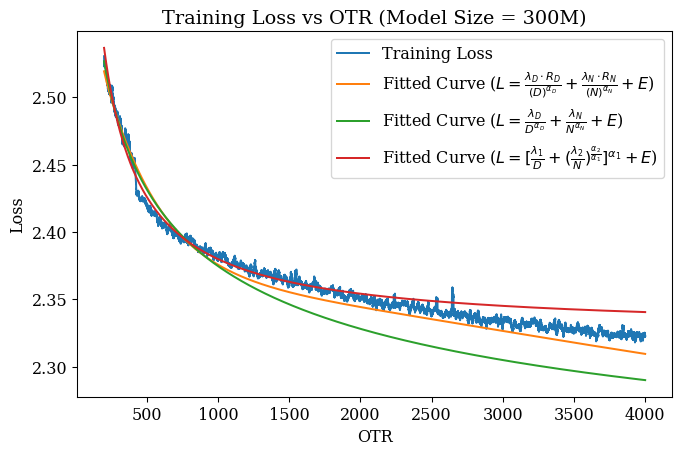

In [149]:
best_ratio = 1 / 0.618
dpi = 96
fig_width = 8
fig_height = fig_width / best_ratio
fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
ax = plt.gca() 

pred_k1_k2 = model_with_k1_k2(params_with_k1_k2, np.array(test_D), np.array(test_N))
pred_hoff = model_hoff(params_hoffman, np.array(test_D), np.array(test_N))
pred_kaplan = model_kapl(params_kaplan, np.array(test_D), np.array(test_N))

plt.plot(np.array(test_D) * (10 ** 9)/ (model_size_300M), test_L, label = 'Training Loss')
plt.plot(np.array(test_D) * (10 ** 9)/ (model_size_300M), pred_k1_k2, label = r'Fitted Curve ($L = \frac{\lambda_D \cdot R_D}{{(D)}^{\alpha_D}} + \frac{\lambda_N \cdot R_N}{{(N)}^{\alpha_N}} + E$)')
plt.plot(np.array(test_D) * (10 ** 9)/ (model_size_300M), pred_hoff, label = r'Fitted Curve ($L = \frac{\lambda_D}{{D}^{\alpha_D}} + \frac{\lambda_N}{{N}^{\alpha_N}} + E$)')
plt.plot(np.array(test_D) * (10 ** 9)/ (model_size_300M), pred_kaplan, label = r'Fitted Curve ($L = [\frac{\lambda_1}{D} + (\frac{\lambda_2}{N})^{\frac{\alpha_2}{\alpha_1}}]^{\alpha_1} + E$)')

plt.title('Training Loss vs OTR (Model Size = 300M)')

plt.legend()
plt.xlabel('OTR')
plt.ylabel('Loss')

# 500M

In [191]:
test_L = []
test_D = []
test_N = []
window_size = 1000
x = np.array(loss_df_500M.Step)
y = np.array(loss_df_500M.Value)
x, y = smooth(x, y, window_size)
# x, y = sample(x, y, upper_value = 3.5, lower_value = 2.1)
x, y = sample_by_otr(x, y, upper_value = 3000, lower_value = 200, model_size=model_size_500M)
z = np.array([model_size_500M] * len(x))/(10 ** 6)
test_L.extend(y)
test_D.extend(list(np.array(x) / (10 ** 9)))
test_N.extend(z)

261469


0.0010111748724254922
0.0027105091135807826
0.002076961721848201
0.0007946959449259132
0.0025484288566197597
0.004138560232344135


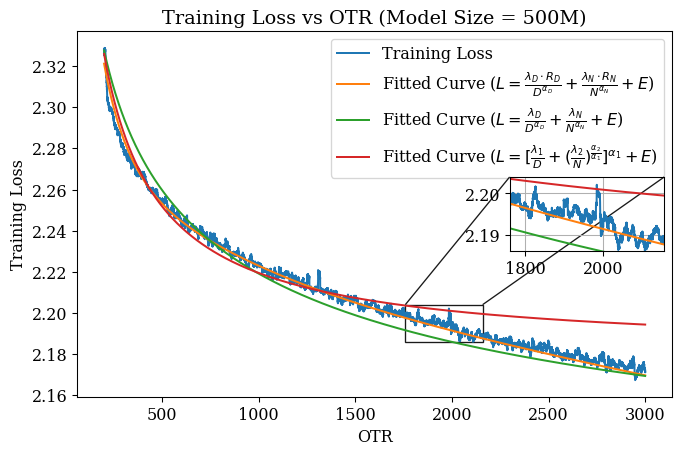

In [195]:
best_ratio = 1 / 0.618
dpi = 96
fig_width = 8
fig_height = fig_width / best_ratio
fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
ax = plt.gca() 


pred_k1_k2 = model_with_k1_k2(params_with_k1_k2, np.array(test_D), np.array(test_N))
pred_hoff = model_hoff(params_hoffman, np.array(test_D), np.array(test_N))
pred_kaplan = model_kapl(params_kaplan, np.array(test_D), np.array(test_N))

plt.plot(np.array(test_D) * (10 ** 3)/ (487.59), test_L, label = 'Training Loss')
plt.plot(np.array(test_D) * (10 ** 3)/ (487.59), pred_k1_k2, label = r'Fitted Curve ($L = \frac{\lambda_D \cdot R_D}{{D}^{\alpha_D}} + \frac{\lambda_N \cdot R_N}{{N}^{\alpha_N}} + E$)')
plt.plot(np.array(test_D) * (10 ** 3)/ (487.59), pred_hoff, label = r'Fitted Curve ($L = \frac{\lambda_D}{{D}^{\alpha_D}} + \frac{\lambda_N}{{N}^{\alpha_N}} + E$)')
plt.plot(np.array(test_D) * (10 ** 3)/ (487.59), pred_kaplan, label = r'Fitted Curve ($L = [\frac{\lambda_1}{D} + (\frac{\lambda_2}{N})^{\frac{\alpha_2}{\alpha_1}}]^{\alpha_1} + E$)')
plt.legend(loc='upper right')
plt.title('Training Loss vs OTR (Model Size = 500M)')

axins = zoomed_inset_axes(ax, 2, loc='center right')  # zoom = 6
axins.plot(np.array(test_D) * (10 ** 3)/ (487.59), test_L, label = 'Training Loss')
axins.plot(np.array(test_D) * (10 ** 3)/ (487.59), pred_k1_k2, label = r'Fitted Curve ($L = \frac{\lambda_D \cdot R_D}{{(D)}^{\alpha_D}} + \frac{\lambda_N \cdot R_N}{{(N)}^{\alpha_N}} + E$)')
axins.plot(np.array(test_D) * (10 ** 3)/ (487.59), pred_hoff, label = r'Fitted Curve ($L = \frac{\lambda_D}{{D}^{\alpha_D}} + \frac{\lambda_N}{{N}^{\alpha_N}} + E$)')
axins.plot(np.array(test_D) * (10 ** 3)/ (487.59), pred_kaplan, label = r'Fitted Curve ($L = [\frac{\lambda_1}{D} + (\frac{\lambda_2}{N})^{\frac{\alpha_2}{\alpha_1}}]^{\alpha_1} + E$)')

# sub region of the original image
x1, x2, y1, y2 = 1759, 2159, 2.186, 2.204
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
# fix the number of ticks on the inset axes
axins.yaxis.get_major_locator().set_params(nbins=1)
axins.xaxis.get_major_locator().set_params(nbins=1)

mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.1")


ax.set_xlabel('OTR', fontsize=12) 
ax.set_ylabel('Training Loss', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
plt.grid()

# 1B

In [244]:
test_L = []
test_D = []
test_N = []
window_size = 1000
x = np.array(loss_df_1B.Step)
y = np.array(loss_df_1B.Value)
x, y = smooth(x, y, window_size)
x, y =  sample_by_otr(x, y, upper_value = 2000, lower_value = 5, model_size=model_size_1B)
z = np.array([model_size_1B] * len(x)) / (10 ** 6)
test_L.extend(y)
test_D.extend(list(np.array(x)/ (10 ** 9)))
test_N.extend(z)

375631


0.002597730671946461
0.012608084607540792
0.00990153112535276
0.0026742879808596006
0.008464491402040685
0.009249869897070486


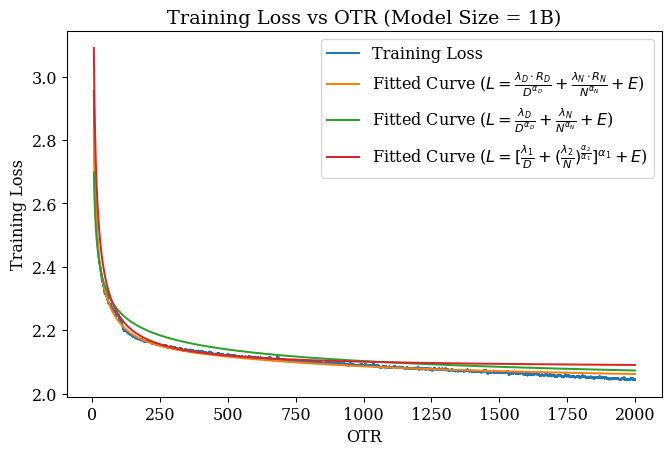

In [245]:
plt.rcParams.update({'font.size':12})
best_ratio = 1 / 0.618
dpi = 96
fig_width = 8
fig_height = fig_width / best_ratio
fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
ax = plt.gca() 

pred_k1_k2 = model_with_k1_k2(params_with_k1_k2, np.array(test_D), np.array(test_N))
pred_hoff = model_hoff(params_hoffman, np.array(test_D), np.array(test_N))
pred_kaplan = model_kapl(params_kaplan, np.array(test_D), np.array(test_N))

plt.plot(np.array(test_D) * (10 ** 9)/ (model_size_1B), test_L, label = 'Training Loss')
plt.plot(np.array(test_D) * (10 ** 9)/ (model_size_1B), pred_k1_k2, label = r'Fitted Curve ($L = \frac{\lambda_D \cdot R_D}{{D}^{\alpha_D}} + \frac{\lambda_N \cdot R_N}{{N}^{\alpha_N}} + E$)')
plt.plot(np.array(test_D) * (10 ** 9)/ (model_size_1B), pred_hoff, label = r'Fitted Curve ($L = \frac{\lambda_D}{{D}^{\alpha_D}} + \frac{\lambda_N}{{N}^{\alpha_N}} + E$)')
plt.plot(np.array(test_D) * (10 ** 9)/ (model_size_1B), pred_kaplan, label = r'Fitted Curve ($L = [\frac{\lambda_1}{D} + (\frac{\lambda_2}{N})^{\frac{\alpha_2}{\alpha_1}}]^{\alpha_1} + E$)')


plt.title('Training Loss vs OTR (Model Size = 1B)')

plt.legend()
plt.xlabel('OTR')
plt.ylabel('Loss')

ax.set_xlabel('OTR', fontsize=12) 
ax.set_ylabel('Training Loss', fontsize=12)
ax.tick_params(axis='both', labelsize=12)

# 2B

In [267]:
test_L = []
test_D = []
test_N = []
window_size = 500
x = np.array(loss_df_2B.Step)
y = np.array(loss_df_2B.Value)
x, y = smooth(x, y, window_size)
x, y =  sample_by_otr(x, y, upper_value = 1000, lower_value = 5, model_size=model_size_2B)
z = np.array([model_size_2B] * len(x)) / (10 ** 6)
test_L.extend(y)
test_D.extend(list(np.array(x)/ (10 ** 9)))
test_N.extend(z)

494698


0.007544968550146876
0.011839281733617056
0.012801588599054035
0.010445598603087058
0.01864987556294305
0.014621993857273075


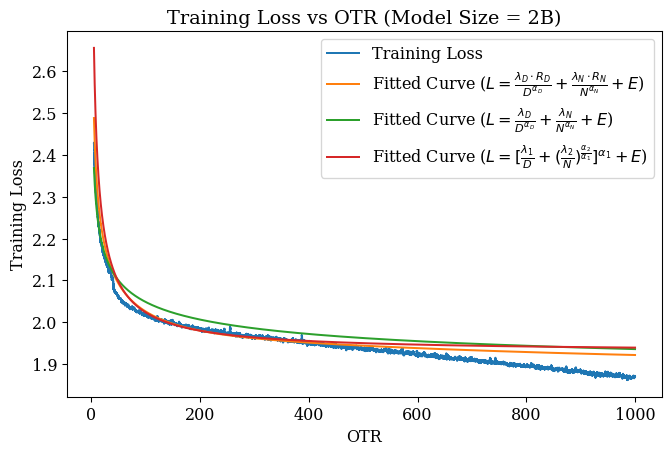

In [268]:
plt.rcParams.update({'font.size':12})
best_ratio = 1 / 0.618
dpi = 96
fig_width = 8
fig_height = fig_width / best_ratio
fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
ax = plt.gca() 

pred_k1_k2 = model_with_k1_k2(params_with_k1_k2, np.array(test_D), np.array(test_N))
pred_hoff = model_hoff(params_hoffman, np.array(test_D), np.array(test_N))
pred_kaplan = model_kapl(params_kaplan, np.array(test_D), np.array(test_N))

plt.plot(np.array(test_D) * (10 ** 9)/ (model_size_2B), test_L, label = 'Training Loss')
plt.plot(np.array(test_D) * (10 ** 9)/ (model_size_2B), pred_k1_k2, label = r'Fitted Curve ($L = \frac{\lambda_D \cdot R_D}{{D}^{\alpha_D}} + \frac{\lambda_N \cdot R_N}{{N}^{\alpha_N}} + E$)')
plt.plot(np.array(test_D) * (10 ** 9)/ (model_size_2B), pred_hoff, label = r'Fitted Curve ($L = \frac{\lambda_D}{{D}^{\alpha_D}} + \frac{\lambda_N}{{N}^{\alpha_N}} + E$)')
plt.plot(np.array(test_D) * (10 ** 9)/ (model_size_2B), pred_kaplan, label = r'Fitted Curve ($L = [\frac{\lambda_1}{D} + (\frac{\lambda_2}{N})^{\frac{\alpha_2}{\alpha_1}}]^{\alpha_1} + E$)')


plt.title('Training Loss vs OTR (Model Size = 2B)')

plt.legend()
plt.xlabel('OTR')
plt.ylabel('Loss')
ax.set_xlabel('OTR', fontsize=12) 
ax.set_ylabel('Training Loss', fontsize=12)
ax.tick_params(axis='both', labelsize=12)

# 4B

In [301]:
test_L = []
test_D = []
test_N = []
window_size = 1000
x = np.array(loss_df_4B.Step)
y = np.array(loss_df_4B.Value)
x, y = smooth(x, y, window_size)
x, y =  sample_by_otr(x, y, upper_value = 500, lower_value = 5, model_size=model_size_4B)
z = np.array([model_size_4B] * len(x)) / (10 ** 6)
test_L.extend(y)
test_D.extend(list(np.array(x)/ (10 ** 9)))
test_N.extend(z)

305853


0.0035439364768730117
0.006770455299020992
0.015176471131696212
0.0033515145055054672
0.0029735169316718445
0.007971464891359862


Text(0, 0.5, 'Loss')

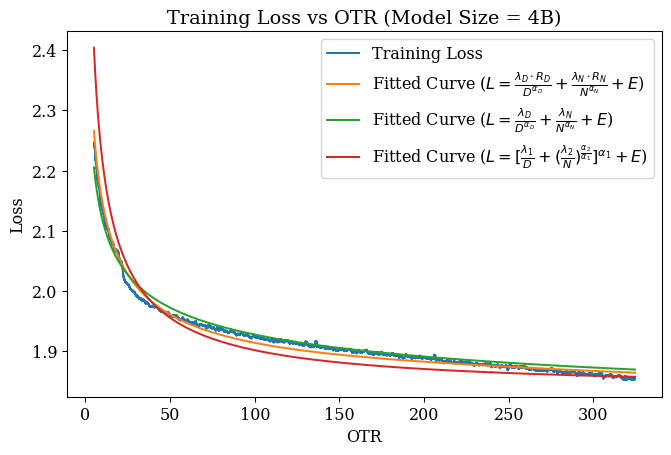

In [302]:
best_ratio = 1 / 0.618
dpi = 96
fig_width = 8
fig_height = fig_width / best_ratio
fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
ax = plt.gca() 

pred_k1_k2 = model_with_k1_k2(params_with_k1_k2, np.array(test_D), np.array(test_N))
pred_hoff = model_hoff(params_hoffman, np.array(test_D), np.array(test_N))
pred_kaplan = model_kapl(params_kaplan, np.array(test_D), np.array(test_N))

plt.plot(np.array(test_D) / 4.7, test_L, label = 'Training Loss')
plt.plot(np.array(test_D) / 4.7, pred_k1_k2, label = r'Fitted Curve ($L = \frac{\lambda_D \cdot R_D}{{D}^{\alpha_D}} + \frac{\lambda_N \cdot R_N}{{N}^{\alpha_N}} + E$)')
plt.plot(np.array(test_D) / 4.7, pred_hoff, label = r'Fitted Curve ($L = \frac{\lambda_D}{{D}^{\alpha_D}} + \frac{\lambda_N}{{N}^{\alpha_N}} + E$)')
plt.plot(np.array(test_D) / 4.7, pred_kaplan, label = r'Fitted Curve ($L = [\frac{\lambda_1}{D} + (\frac{\lambda_2}{N})^{\frac{\alpha_2}{\alpha_1}}]^{\alpha_1} + E$)')

plt.legend(loc='upper right')
plt.title('Training Loss vs OTR (Model Size = 4B)')

ax.set_xlabel('OTR', fontsize=12) 
ax.set_ylabel('Training Loss', fontsize=12)
ax.tick_params(axis='both', labelsize=12)

plt.xlabel('OTR')
plt.ylabel('Loss')

# 7B

In [375]:
test_L = []
test_D = []
test_N = []
window_size = 500
x = np.array(loss_df_7B.Step)
y = np.array(loss_df_7B.Value)
x, y = smooth(x, y, window_size)
x, y =  sample_by_otr(x, y, upper_value = 200, lower_value = 0.5, model_size=model_size_7B)
z = np.array([model_size_7B] * len(x)) / (10 ** 6)
test_L.extend(y)
test_D.extend(list(np.array(x)/ (10 ** 9)))
test_N.extend(z)

288087


0.012072493236613564
0.012831614080924175
0.03634155998351901
0.0025411633823551973
0.003970401346287458
0.005531430350564677


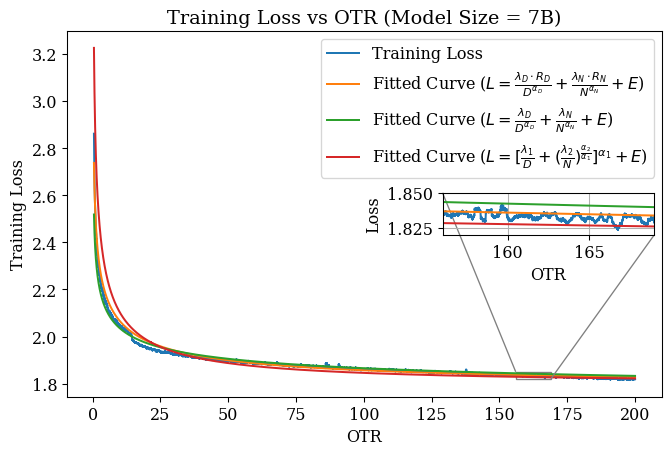

In [377]:
best_ratio = 1 / 0.618
dpi = 96
fig_width = 8
fig_height = fig_width / best_ratio
fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
ax = plt.gca() 

pred_k1_k2 = model_with_k1_k2(params_with_k1_k2, np.array(test_D), np.array(test_N))
pred_hoff = model_hoff(params_hoffman, np.array(test_D), np.array(test_N))
pred_kaplan = model_kapl(params_kaplan, np.array(test_D), np.array(test_N))

plt.plot(np.array(test_D) / (7.03), test_L, label = 'Training Loss')
plt.plot(np.array(test_D) / (7.03), pred_k1_k2, label = r'Fitted Curve ($L = \frac{\lambda_D \cdot R_D}{{D}^{\alpha_D}} + \frac{\lambda_N \cdot R_N}{{N}^{\alpha_N}} + E$)')
plt.plot(np.array(test_D) / (7.03), pred_hoff, label = r'Fitted Curve ($L = \frac{\lambda_D}{{D}^{\alpha_D}} + \frac{\lambda_N}{{N}^{\alpha_N}} + E$)')
plt.plot(np.array(test_D) / (7.03), pred_kaplan, label = r'Fitted Curve ($L = [\frac{\lambda_1}{D} + (\frac{\lambda_2}{N})^{\frac{\alpha_2}{\alpha_1}}]^{\alpha_1} + E$)')

plt.legend(loc='upper right')
plt.title('Training Loss vs OTR (Model Size = 7B)')


axins = zoomed_inset_axes(ax, 6, loc='center right')  # zoom = 6
axins.plot(np.array(test_D) / (7.03), test_L, label = 'Training Loss')
axins.plot(np.array(test_D) / (7.03), pred_k1_k2, label = r'Fitted Curve ($L = \frac{\lambda_D * R_D}{{(D)}^{\alpha_D}} + \frac{\lambda_N}{{(N)}^{\alpha_N}} + E$)')
axins.plot(np.array(test_D) / (7.03), pred_hoff, label = r'Fitted Curve ($L = \frac{\lambda_D}{{D}^{\alpha_D}} + \frac{\lambda_N}{{N}^{\alpha_N}} + E$)')
axins.plot(np.array(test_D) / (7.03), pred_kaplan, label = r'Fitted Curve ($L = [\frac{\lambda_1}{D} + (\frac{\lambda_2}{N})^{\frac{\alpha_2}{\alpha_1}}]^{\alpha_1} + E$)')

# sub region of the original image
x1, x2, y1, y2 = 156, 169, 1.82, 1.85
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# fix the number of ticks on the inset axes
axins.yaxis.get_major_locator().set_params(nbins=1)
axins.xaxis.get_major_locator().set_params(nbins=1)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")


ax.set_xlabel('OTR', fontsize=12) 
ax.set_ylabel('Training Loss', fontsize=12)
ax.tick_params(axis='both', labelsize=12)

plt.xlabel('OTR')
plt.ylabel('Loss')
plt.grid()